In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
       header=None)

x = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

pipe_lr = Pipeline([('sc', StandardScaler()),
                        ('pca', PCA(n_components=2)),
                        ('clf', LogisticRegression(random_state=1))
                       ])

pipe_lr.fit(x_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(x_test, y_test))


Test Accuracy: 0.947


In [7]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

kfold = StratifiedKFold(n_splits=10).split(x_train, y_train)
scores = list()

for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(x_train[train], y_train[train])
    score = pipe_lr.score(x_train[test], y_train[test])
    scores.append(score)
    print("Fold: {} Class Dist.: {}, Acc: {}".format(k+1, np.bincount(y_train[test]), score))

print("CV score: {}/{}".format(np.mean(scores), np.std(scores)))

Fold: 1 Class Dist.: [29 17], Acc: 0.8913043478260869
Fold: 2 Class Dist.: [29 17], Acc: 0.9782608695652174
Fold: 3 Class Dist.: [29 17], Acc: 0.9782608695652174
Fold: 4 Class Dist.: [29 17], Acc: 0.9130434782608695
Fold: 5 Class Dist.: [29 17], Acc: 0.9347826086956522
Fold: 6 Class Dist.: [28 17], Acc: 0.9777777777777777
Fold: 7 Class Dist.: [28 17], Acc: 0.9333333333333333
Fold: 8 Class Dist.: [28 17], Acc: 0.9555555555555556
Fold: 9 Class Dist.: [28 17], Acc: 0.9777777777777777
Fold: 10 Class Dist.: [28 17], Acc: 0.9555555555555556
CV score: 0.9495652173913044/0.029190259109272025


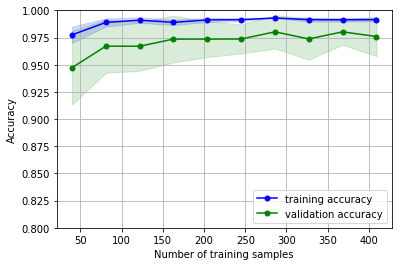

In [16]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([('sc', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', random_state=1))
                   ])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                        X=x_train, 
                                                        y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10, 
                                                        n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', marker='o', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()


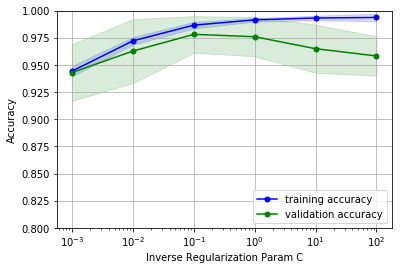

In [19]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_lr, 
                                             X=x_train, 
                                             y=y_train,
                                             param_name='clf__C',
                                             param_range=param_range,
                                             cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(param_range, test_mean, color='green', marker='o', markersize=5, label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.xlabel('Inverse Regularization Param C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = Pipeline([('sc', StandardScaler()), ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
        {'clf__C': param_range, 'clf__kernel': ['linear']},
        {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}
]

gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy',cv=10)
gs = gs.fit(x_train, y_train)
print("Best Accuracy score: {}".format(gs.best_score_))
print("Best Param Combination: {}".format(gs.best_params_))

Best Accuracy score: 0.978021978021978
Best Param Combination: {'clf__kernel': 'linear', 'clf__C': 0.1}


In [28]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(x_train, y_train)
y_pred = pipe_svc.predict(x_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


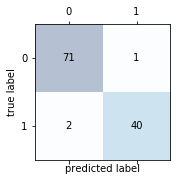

In [29]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)

for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,s=confmat[i, j],va='center', ha='center')

plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: {}".format(precision_score(y_true=y_test, y_pred=y_pred)))
print("Recall: {}".format(recall_score(y_true=y_test, y_pred=y_pred)))
print("F1: {}".format(f1_score(y_true=y_test, y_pred=y_pred)))

Precision: 0.975609756097561
Recall: 0.9523809523809523
F1: 0.963855421686747


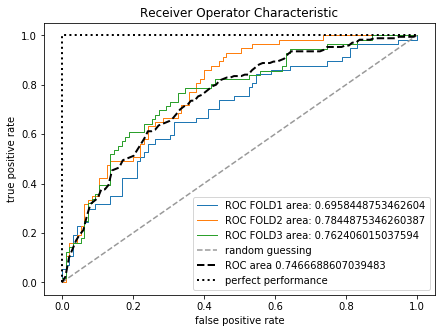

In [33]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

X_train2 = x_train[:, [4, 14]]
cv = StratifiedKFold(n_splits=3).split(x_train, y_train)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

len_cv = 0
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],probas[:, 1],pos_label=1)
    mean_tpr = mean_tpr + interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label="ROC FOLD{} area: {}".format(i+1, roc_auc))
    len_cv = len_cv + 1

plt.plot([0,1], [0,1], linestyle='--', color=(0.6, 0.6, 0.6), label='random guessing')

mean_tpr = mean_tpr/len_cv
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label="ROC area {}".format(mean_auc), lw=2)

plt.plot([0, 0, 1], [0, 1, 1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()
